Training a Feed Forward Neural Network on Google Colab TPU
----

This notebook fits a deep feed-forward neural network.

After some trial and error, arrived at two key elements:
1. The data needs to be normalized.
1. Using dropout layers for regularization.



# Setup

## Imports

In [1]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


In [2]:
import sys
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, Union, List
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import drive, runtime
from keras_tuner import HyperParameters, BayesianOptimization, RandomSearch, Objective
# sys.path.append("../src")

## Mounting Drive

In [3]:
drive_root = '/gdrive'
drive.mount(drive_root)
project_folder = drive_root + '/My Drive/learning/Data Science/Springboard/Capstone Projects/2/rnn'
train_data_path = project_folder + '/tx_train_balanced.csv'
test_data_path = project_folder + '/tx_test.csv'
mcc_rates_path = project_folder + '/mcc_rates.csv'
output_path = project_folder + '/fraud_prediction_ffnn.h5'
log_path = project_folder + '/training_logs'

Mounted at /gdrive


## TPU setup

In [4]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# or: tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# Preprocessing

## Transformer classes

In [5]:
def convert_multicat(df: pd.DataFrame, colname: str, copy:bool=True) -> Tuple[pd.DataFrame, List[str]]:
    '''(Optionally copies `df` and) converts the categorical column `colname` into dummies. Allows for membership in multiple categories separated by a single comma, e.g. entry "a,b" will be converted into `True` for columns `a` and `b`'''
    if copy:
        dummy_df = df.copy()
    else:
        dummy_df = df
    cats = set()
    for entry in dummy_df[colname].dropna().unique().tolist():
        for cat in entry.split(','):
            cats.add(cat)
    cats = list(cats)
    for cat in cats:
        dummy_df[cat] = dummy_df[colname].str.contains(cat).fillna(False)
    dummy_df.drop(columns=colname, inplace=True)

    return dummy_df, cats



class MakeDummies(BaseEstimator, TransformerMixin):
    """Transforms categorical columns into dummies. Can handle multi-category columns"""
    def __init__(self, multicat_col: str, drop_first=True, dummy_cols:Union[List[str], str]='auto') -> None:
        super().__init__()
        self.multicat_col = multicat_col
        self.drop_first = drop_first
        self.dummy_cols= dummy_cols

    def fit(self, X, y=None):
        _, self.cats = convert_multicat(X, self.multicat_col)
        return self

    def fit_transform(self, X, y=None):
        dummy_df, self.cats = convert_multicat(X, self.multicat_col)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)
        return dummy_df

    def transform(self, X, y=None):
        dummy_df = X.copy()
        for cat in self.cats:
            dummy_df[cat] = dummy_df[self.multicat_col].str.contains(cat).fillna(False)
        dummy_df.drop(columns=self.multicat_col, inplace=True)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)

        return dummy_df



class MCCRates(BaseEstimator, TransformerMixin):
    """Transforms MCC codes into average fraud rates, based on saved data or a specific training set. Note: only accepts data frames"""

    mcc_rates_path = mcc_rates_path

    def __init__(self, use_saved=None) -> None:
        super().__init__()
        self.mcc_rates = pd.read_csv(use_saved, index_col=0) if use_saved else None

    def fit(self, X, y=None):
        if self.mcc_rates is None:
            self.mcc_rates = (
                X.copy()
                .groupby('mcc')
                .agg('mean')
                .rename({'mean':'mcc_fraud_rate'}, axis=1)
            )
        return self

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def transform(self, X, y=None):
        X_transformed = X.merge(self.mcc_rates, how='left', left_on='mcc', right_index=True)
        X_transformed.drop(columns='mcc', inplace=True)
        return X_transformed

## Loading data

In [6]:
# load balanced training data and test data
training_data_raw = pd.read_csv(train_data_path, index_col=0)
testing_data_raw = pd.read_csv(test_data_path, index_col=0)

print(training_data_raw.head(3).T)

                                7977       7979       7987
user                               5          5          5
card                               0          0          0
amount                         11.45      471.0     398.93
mcc                             5311       3504       3504
errors                           NaN        NaN        NaN
is_fraud                        True       True       True
tx_type                       online     online     online
card_brand                      Visa       Visa       Visa
card_type                     Credit     Credit     Credit
has_chip                        True       True       True
cards_issued                       2          2          2
credit_limit                  9900.0     9900.0     9900.0
gender                          Male       Male       Male
latitude                       41.55      41.55      41.55
longitude                      -90.6      -90.6      -90.6
per_capita_income_zipcode    20599.0    20599.0    20599

## Processing data

In [7]:
val_source = "test" # @param ['test', 'train']
val_share = 0.1 # @param {type: "slider", min:0, max:1, step:0.05}

mcc_converter = MCCRates(mcc_rates_path)
dummy_converter = MakeDummies('errors')
normalizer = StandardScaler()

if val_source == 'train':
    X_train, X_val, y_train, y_val = train_test_split(
        training_data_raw.drop(columns=['is_fraud', 'card', 'user']),
        training_data_raw.is_fraud,
        test_size=val_share,
        stratify=training_data_raw.is_fraud
    )
    y_test = testing_data_raw.is_fraud
    X_test = testing_data_raw.drop(columns=['is_fraud','card', 'user'])
else:
    X_test, X_val, y_test, y_val = train_test_split(
        testing_data_raw.drop(columns=['is_fraud', 'card', 'user']),
        testing_data_raw.is_fraud,
        test_size=val_share,
        stratify=testing_data_raw.is_fraud
    )
    y_train = training_data_raw.is_fraud
    X_train = training_data_raw.drop(columns=['is_fraud','card', 'user'])

y_train = y_train.to_numpy(dtype=np.float32, copy=True)
X_train = mcc_converter.fit_transform(X_train)
X_train = dummy_converter.fit_transform(X_train)
print("Transformed data:\n", X_train.head(3).T)
X_train = normalizer.fit_transform(X_train.to_numpy()).astype(np.float32)

y_val = y_val.to_numpy(dtype=np.float32, copy=True)
X_val = mcc_converter.transform(X_val)
X_val = dummy_converter.transform(X_val)
X_val = normalizer.transform(X_val.to_numpy()).astype(np.float32)

y_test = y_test.to_numpy(dtype=np.float32, copy=True)
X_test = mcc_converter.transform(X_test)
X_test = dummy_converter.transform(X_test)
X_test = normalizer.transform(X_test.to_numpy()).astype(np.float32)

# positive_training_share = np.sum(y_train) / np.product(y_train.shape)
# training_weights = np.where(y_train==1., 1./positive_training_share, 1.).astype(np.float32)

Transformed data:
                                 7977       7979       7987
amount                         11.45      471.0     398.93
has_chip                        True       True       True
cards_issued                       2          2          2
credit_limit                  9900.0     9900.0     9900.0
latitude                       41.55      41.55      41.55
longitude                      -90.6      -90.6      -90.6
per_capita_income_zipcode    20599.0    20599.0    20599.0
yearly_income_person         41997.0    41997.0    41997.0
total_debt                       0.0        0.0        0.0
fico_score                       704        704        704
num_credit_cards                   3          3          3
home_city                      False      False      False
home_state                     False      False      False
home_zip                       False      False      False
overseas                       False      False      False
user_age                   38.523288 

In [8]:
print("Training", "Validation", "Testing")
print(X_train.shape, y_train.shape, '|', X_val.shape, y_val.shape, '|', X_test.shape, y_test.shape)
print(y_train.sum(), y_val.sum(), y_test.sum())
print("First training observation and label:", X_train[0,:], X_train.dtype, y_train[0], y_train.dtype)
print("First training observation and label:", X_val[0,:], X_val.dtype, y_val[0], y_val.dtype)

Training Validation Testing
(27599, 35) (27599,) | (117671, 35) (117671,) | (1059036, 35) (1059036,)
13850.0 142.0 1273.0
First training observation and label: [-0.41552633  0.3045107   0.9016859  -0.37503085  0.8631322   0.03799457
 -0.20152299 -0.08792743 -1.1426392  -0.14557597 -0.59956527 -0.6455337
 -0.92420155 -0.5870714  -0.3603558  -0.5948774  -0.4367393  -0.6679103
  1.8498534  -0.08417551 -0.04427673 -0.08011223 -0.00851303 -0.04589064
 -0.06905929 -0.11068034 -0.0426022   1.3233937  -0.8446766  -0.16941158
 -1.0362748   1.2562408  -1.2314827  -0.30924615  1.0394379 ] float32 1.0 float32
First training observation and label: [-3.9350784e-01 -3.2839568e+00 -1.0548853e+00  1.1255056e+01
 -1.4790636e+00 -2.5863990e-01  7.3433361e+00  7.1235533e+00
  2.0794628e+00 -4.2478791e-01  6.4040488e-01  1.5491059e+00
  1.0820150e+00 -5.8707142e-01 -3.6035579e-01  4.2702869e-01
 -4.3673930e-01 -2.6297513e-01 -2.4538472e-01 -2.2429524e-01
 -4.4276726e-02 -8.0112234e-02 -8.5130278e-03 -4.589

In [9]:
multiplier = 64
batch_size = multiplier * strategy.num_replicas_in_sync
print(f"Batch size: {multiplier}*{strategy.num_replicas_in_sync}={batch_size}")

n_train, num_cols = X_train.shape

# data_tuple = (X_train, y_train, training_weights) # when not using weighting by loss function
def tensor_tuple(*data):
    return tuple(tf.convert_to_tensor(a) for a in data)

training_data = (
                tf.data.Dataset.from_tensor_slices(tensor_tuple(X_train, y_train))
                    .shuffle(n_train)
                    .repeat()
                    .batch(batch_size, drop_remainder=True)
)

Batch size: 64*8=512


# Model setup

Model builder

In [10]:
def create_model(
    width, depth, # hidden layer dimensions
    activation, hinge_loss, # activation and loss
    kernel_l1, kernel_l2, bias_l1, bias_l2, # weight regularization
    dropout, gn, batchnorm, # normalization/noise
    num_cols=num_cols # input shape
):
    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=num_cols))
    model.add(keras.layers.GaussianNoise(gn))
    # model.add(keras.layers.GaussianNoise(0.1))

    # adds depth dense layers, of size width
    for _ in range(depth):
        kernel_regularizer=keras.regularizers.L1L2(l1=kernel_l1, l2=kernel_l2)
        bias_regularizer=keras.regularizers.L1L2(l1=bias_l1, l2=bias_l2)
        model.add(keras.layers.Dense(
            width,
            activation=None,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer
        ))

        if batchnorm:
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Activation(activation))

        if dropout >= 0.01:
            model.add(keras.layers.Dropout(rate=dropout))

    # model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.add(keras.layers.Dense(1, activation=None)) # "logit" results

    if hinge_loss:
        loss = keras.losses.Hinge()
    else:
        loss = keras.losses.BinaryCrossentropy(from_logits=True)

    pr_auc = keras.metrics.AUC(curve='PR', name="pr_auc", from_logits=True)

    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=[pr_auc]
    )
    return model



Hyperparameter search space

In [11]:
def search_model(hp:HyperParameters):
    width = hp.Choice("width", [64, 128, 256, 512])
    depth = hp.Int("depth", min_value=3, max_value=15, step=4)
    activation = hp.Choice("activation", ['tanh', 'relu'])
    # kernel_l1 = hp.Float('kernel_l1', min_value=1e-5, max_value=0.05, sampling='log') # always minimized
    kernel_l1 = 0
    kernel_l2 = hp.Float('kernel_l2', min_value=1e-5, max_value=0.1, sampling='log')
    bias_l1 = hp.Float('bias_l1', min_value=1e-5, max_value=0.1, sampling='log')
    bias_l2 = hp.Float('bias_l2', min_value=1e-3, max_value=0.1, sampling='log')
    dropout = hp.Float('dropout', min_value=1e-4, max_value=0.6)
    gn = hp.Float('gn', min_value=0.001, max_value=1.25)
    # batchnorm = hp.Boolean('batchnorm') # clearly only works with this on
    batchnorm = True
    hinge_loss = hp.Boolean("hinge_loss")

    return create_model(
        width, depth,
        activation, hinge_loss,
        kernel_l1, kernel_l2, bias_l1, bias_l2,
        dropout, gn, batchnorm
    )

# Training

The Tuner is designed to save the model state with each epoch. But with a TPU strategy, this would need to be a GSCloud bucket. Rather than dealing with that, this class overloads the training method to remove the save step.

In [12]:
import copy

class TunerCallback(keras.callbacks.Callback):
    def __init__(self, tuner, trial):
        super().__init__()
        self.tuner = tuner
        self.trial = trial

    def on_epoch_begin(self, epoch, logs=None):
        self.tuner.on_epoch_begin(self.trial, self.model, epoch, logs=logs)

    def on_batch_begin(self, batch, logs=None):
        self.tuner.on_batch_begin(self.trial, self.model, batch, logs)

    def on_batch_end(self, batch, logs=None):
        self.tuner.on_batch_end(self.trial, self.model, batch, logs)

    def on_epoch_end(self, epoch, logs=None):
        self.tuner.on_epoch_end(self.trial, self.model, epoch, logs=logs)

tuner_type = BayesianOptimization # @param ["BayesianOptimization", "RandomSearch"] {type:"raw"}

class NoCheckpointTuner(BayesianOptimization):
    # def on_trial_end(self, trial):
    #     """Called at the end of a trial.

    #     Args:
    #         trial: A `Trial` instance.
    #     """
    #     self.oracle.end_trial(trial)
        # self.save()

    def run_trial(self, trial, *args, **kwargs):
        """Evaluates a set of hyperparameter values.

        This method is called multiple times during `search` to build and
        evaluate the models with different hyperparameters and return the
        objective value.

        Example:

        You can use it with `self.hypermodel` to build and fit the model.

        ```python
        def run_trial(self, trial, *args, **kwargs):
            hp = trial.hyperparameters
            model = self.hypermodel.build(hp)
            return self.hypermodel.fit(hp, model, *args, **kwargs)
        ```

        You can also use it as a black-box optimizer for anything.

        ```python
        def run_trial(self, trial, *args, **kwargs):
            hp = trial.hyperparameters
            x = hp.Float("x", -2.0, 2.0)
            y = x * x + 2 * x + 1
            return y
        ```

        Args:
            trial: A `Trial` instance that contains the information needed to
                run this trial. Hyperparameters can be accessed via
                `trial.hyperparameters`.
            *args: Positional arguments passed by `search`.
            **kwargs: Keyword arguments passed by `search`.

        Returns:
            A `History` object, which is the return value of `model.fit()`, a
            dictionary, a float, or a list of one of these types.

            If return a dictionary, it should be a dictionary of the metrics to
            track. The keys are the metric names, which contains the
            `objective` name. The values should be the metric values.

            If return a float, it should be the `objective` value.

            If evaluating the model for multiple times, you may return a list
            of results of any of the types above. The final objective value is
            the average of the results in the list.
        """
        # Not using `ModelCheckpoint` to support MultiObjective.
        # It can only track one of the metrics to save the best model.
        # model_checkpoint = tuner_utils.SaveBestEpoch(
        #     objective=self.oracle.objective,
        #     filepath=self._get_checkpoint_fname(trial.trial_id),
        # )
        original_callbacks = kwargs.pop("callbacks", [])

        # Run the training process multiple times.
        histories = []
        for execution in range(self.executions_per_trial):
            copied_kwargs = copy.copy(kwargs)
            callbacks = self._deepcopy_callbacks(original_callbacks)
            self._configure_tensorboard_dir(callbacks, trial, execution)
            callbacks.append(TunerCallback(self, trial))
            # Only checkpoint the best epoch across all executions.
            # callbacks.append(model_checkpoint)
            copied_kwargs["callbacks"] = callbacks
            obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)

            histories.append(obj_value)
        return histories

In [13]:
max_trials = 100 # @param {type:"slider", min:10, max:100, step:10}
per_trial = 2 # @param {type:"slider", min:1, max:5, step:1}
epochs = 20 # @param {type:"slider", min:0, max:100, step:5}

tuner = NoCheckpointTuner(
    hypermodel=search_model,
    objective=Objective("val_pr_auc", direction="max"),
    max_trials=max_trials,
    executions_per_trial=per_trial,
    distribution_strategy=strategy,
    overwrite=True,
    directory=log_path,
    project_name='fraud_ffnn'
)


tuner.search(
    training_data,
    steps_per_epoch=n_train//batch_size,
    validation_data=(X_val, y_val),
    validation_batch_size=batch_size,
    epochs=epochs
)

Trial 100 Complete [00h 03m 38s]
val_pr_auc: 0.1299591213464737

Best val_pr_auc So Far: 0.14452007412910461
Total elapsed time: 06h 25m 52s


In [14]:
%%capture results_output
tuner.results_summary()

In [15]:
current_time = datetime.now().strftime('%Y%m%d%H%M%S')
with open(log_path+f'/tuning_{current_time}.txt', mode='w') as f:
    print(results_output, file=f)

# Evaluation

In [16]:
with strategy.scope():
    model = search_model(tuner.get_best_hyperparameters(1)[0])

training_history = model.fit(
    training_data,
    steps_per_epoch=n_train//batch_size,
    validation_data=(X_val, y_val),
    validation_batch_size=batch_size,
    validation_freq=2,
    epochs=epochs+5
)

Epoch 1/25
53/53 [==============================] - 11s 14ms/step - loss: 2.2823 - pr_auc: 0.5523
Epoch 2/25
53/53 [==============================] - 7s 131ms/step - loss: 1.9231 - pr_auc: 0.7434 - val_loss: 1.5548 - val_pr_auc: 0.0329
Epoch 3/25
53/53 [==============================] - 1s 15ms/step - loss: 1.6208 - pr_auc: 0.8259
Epoch 4/25
53/53 [==============================] - 5s 93ms/step - loss: 1.4062 - pr_auc: 0.8373 - val_loss: 1.1037 - val_pr_auc: 0.0482
Epoch 5/25
53/53 [==============================] - 1s 17ms/step - loss: 1.2229 - pr_auc: 0.8503
Epoch 6/25
53/53 [==============================] - 3s 65ms/step - loss: 1.0621 - pr_auc: 0.8626 - val_loss: 0.8708 - val_pr_auc: 0.0695
Epoch 7/25
53/53 [==============================] - 1s 14ms/step - loss: 0.9324 - pr_auc: 0.8675
Epoch 8/25
53/53 [==============================] - 4s 72ms/step - loss: 0.8244 - pr_auc: 0.8692 - val_loss: 0.7005 - val_pr_auc: 0.1043
Epoch 9/25
53/53 [==============================] - 1s 15ms/st

In [17]:
def predict_prob(model, X):
    raw_pred = model.predict(X, batch_size=batch_size).reshape(-1)
    return 1 / (1 + np.exp(-raw_pred))

In [18]:
y_pred, y_pred_train, y_pred_val = (predict_prob(model, X) for X in (X_test, X_train, X_val))

230/230 [==============================] - 3s 12ms/step


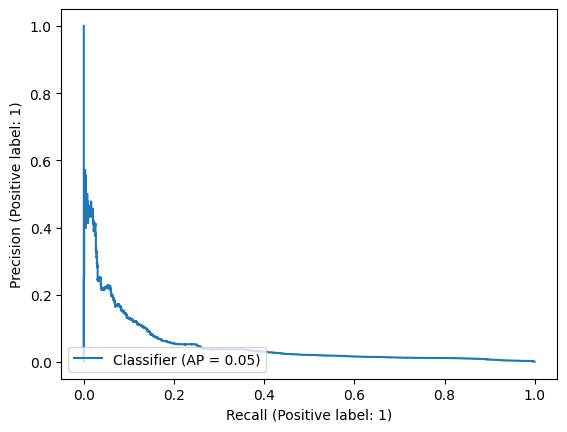

In [19]:
from sklearn.metrics import PrecisionRecallDisplay
p_r_curve = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
# plt.axis((0., 1., 0., 0.25));

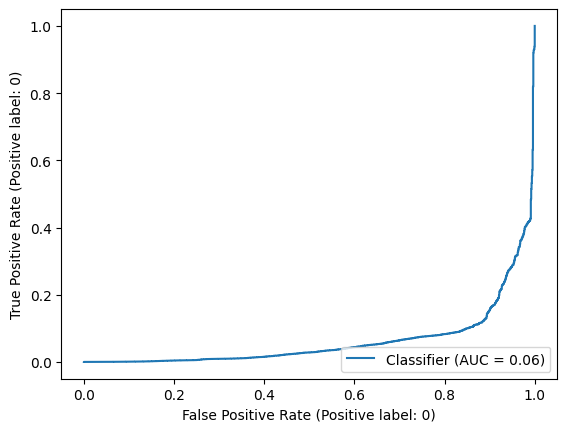

In [20]:
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=0)

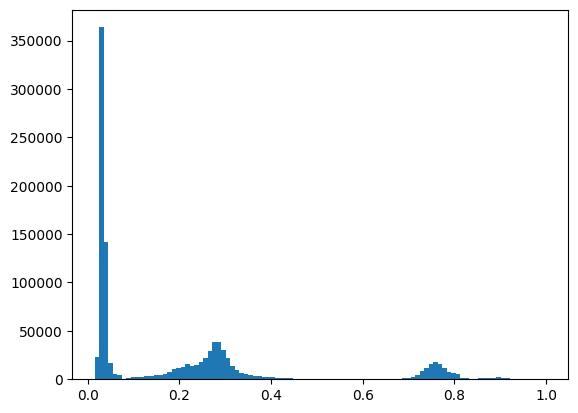

In [21]:
plt.hist(y_pred, bins=100);

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

sorted_idx = np.argsort(y_pred)
fixed_label = np.zeros_like(y_pred)
fixed_label[-int(2*np.sum(y_test)):] = 1
print(classification_report(y_test[sorted_idx], fixed_label))
print(confusion_matrix(y_test[sorted_idx], fixed_label))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1057763
         1.0       0.08      0.15      0.10      1273

    accuracy                           1.00   1059036
   macro avg       0.54      0.58      0.55   1059036
weighted avg       1.00      1.00      1.00   1059036

[[1055414    2349]
 [   1076     197]]


              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86     13749
         1.0       0.88      0.84      0.86     13850

    accuracy                           0.86     27599
   macro avg       0.86      0.86      0.86     27599
weighted avg       0.86      0.86      0.86     27599



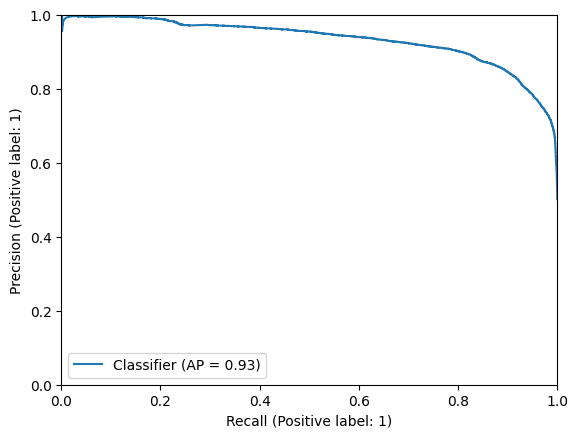

In [23]:
print(classification_report(y_train, np.where(y_pred_train>0.5,1.,0.)))
p_r_curve_train = PrecisionRecallDisplay.from_predictions(y_train, y_pred_train)
plt.axis((0., 1., 0., 1));

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94    117529
         1.0       0.01      0.86      0.02       142

    accuracy                           0.88    117671
   macro avg       0.50      0.87      0.48    117671
weighted avg       1.00      0.88      0.94    117671



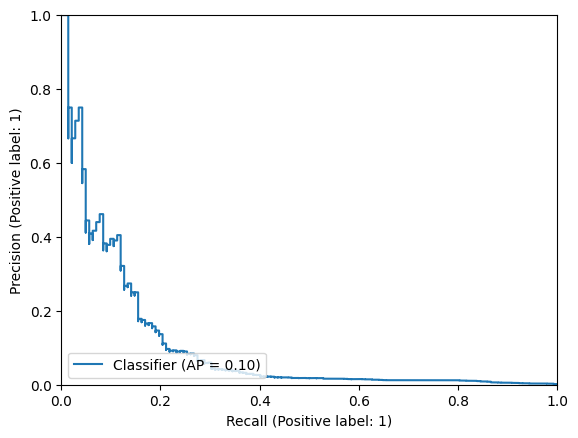

In [24]:
# y_pred_val = model.predict(X_val, batch_size=batch_size).reshape(-1)
print(classification_report(y_val, np.where(y_pred_val>0.5,1.,0.)))
p_r_curve_val = PrecisionRecallDisplay.from_predictions(y_val, y_pred_val)
plt.axis((0., 1., 0., 1));

In [ ]:
end_session = True # @param {type:"boolean"}
if end_session:
    drive.flush_and_unmount()
    runtime.unassign()